In [1]:
!git clone https://github.com/calvin050101/Waste-Type-Classification.git
%cd repo

Cloning into 'Waste-Type-Classification'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 10 (from 2)
Receiving objects: 100% (11/11), 93.01 MiB | 25.91 MiB/s, done.
Resolving deltas: 100% (1/1), done.
[Errno 2] No such file or directory: 'repo'
/content


# Importing Data

In [2]:
import os, pathlib, tensorflow as tf
from tensorflow import keras

In [3]:
DATA_DIR = "/content/Waste-Type-Classification/garbage_classification.zip"
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
import zipfile

# Define the directory to extract the dataset
dataset_dir = "/content/waste_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(DATA_DIR, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")

Dataset extracted to: /content/waste_dataset


# Data Preprocessing

In [5]:
IMG_PATH = "/content/waste_dataset/garbage_classification"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 6500 files belonging to 10 classes.
Using 5200 files for training.
Found 6500 files belonging to 10 classes.
Using 1300 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print(num_classes, "classes")

Classes: ['biological', 'cardboard', 'clothes', 'ewaste', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
10 classes


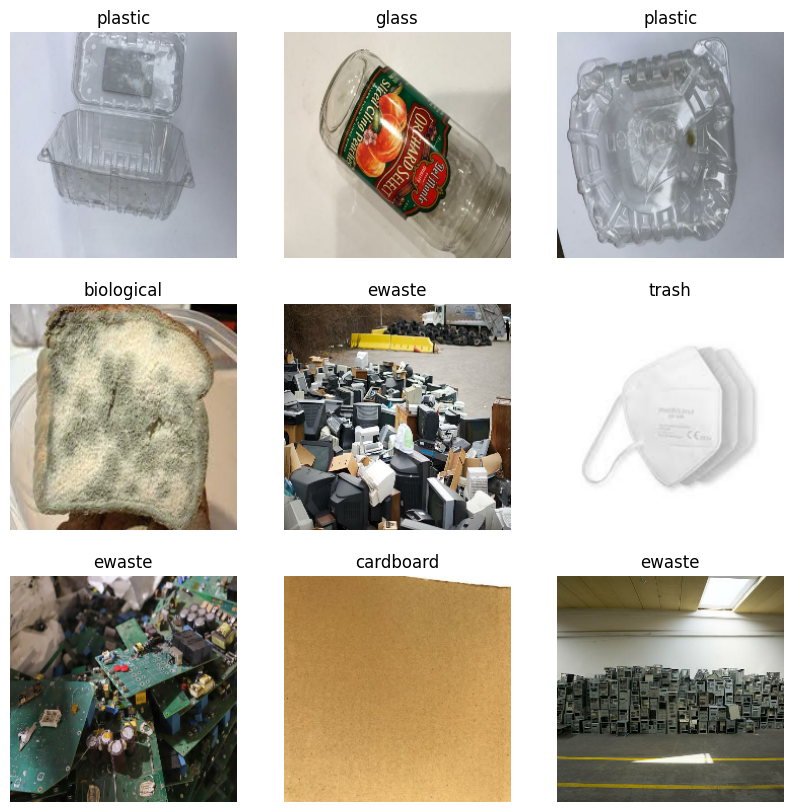

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.05),
], name="augment")

# Model Training

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base = EfficientNetB0(include_top=False,
                      weights="imagenet",
                      input_shape=(224, 224, 3))
base.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5,
                                  restore_best_weights=True,
                                  monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)
]

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.6185 - loss: 1.2768 - val_accuracy: 0.9054 - val_loss: 0.3467 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9031 - loss: 0.3598 - val_accuracy: 0.9208 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9255 - loss: 0.2612 - val_accuracy: 0.9269 - val_loss: 0.2142 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9337 - loss: 0.2210 - val_accuracy: 0.9331 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9452 - loss: 0.1864 - val_accuracy: 0.9400 - val_loss: 0.1829 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9497 - loss: 0.1711 - val_accuracy: 0.9446 - val_loss: 0.1693 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9563 - 

In [14]:
base.trainable = True

# Fine-tune from this layer onwards
for layer in base.layers:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tuned_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 252ms/step - accuracy: 0.9768 - loss: 0.0776 - val_accuracy: 0.9554 - val_loss: 0.1282 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.9830 - loss: 0.0573 - val_accuracy: 0.9554 - val_loss: 0.1275 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 232ms/step - accuracy: 0.9851 - loss: 0.0505 - val_accuracy: 0.9585 - val_loss: 0.1288 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.9841 - loss: 0.0481 - val_accuracy: 0.9638 - val_loss: 0.1212 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.9866 - loss: 0.0448 - val_accuracy: 0.9631 - val_loss: 0.1155 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 0.9873 - loss: 0.0374 - val_accuracy: 0.9623 - val_loss: 0.1177 - learning_rate: 1.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 23

# Model Testing

In [15]:
# Get best epoch
best_epoch = tf.math.argmax(tuned_history.history["val_accuracy"]) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 9


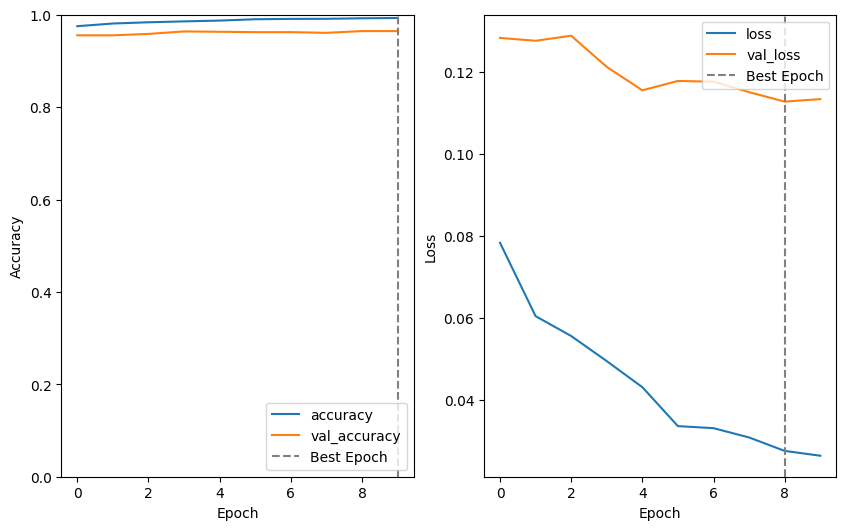

In [16]:
# Plot history graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(tuned_history.history["accuracy"], label="accuracy")
plt.plot(tuned_history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.axvline(best_epoch, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(tuned_history.history["loss"], label="loss")
plt.plot(tuned_history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axvline(best_epoch - 1, linestyle="--", color="gray", label="Best Epoch")
plt.legend(loc="upper right")

plt.show()

In [17]:
import numpy as np

y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step


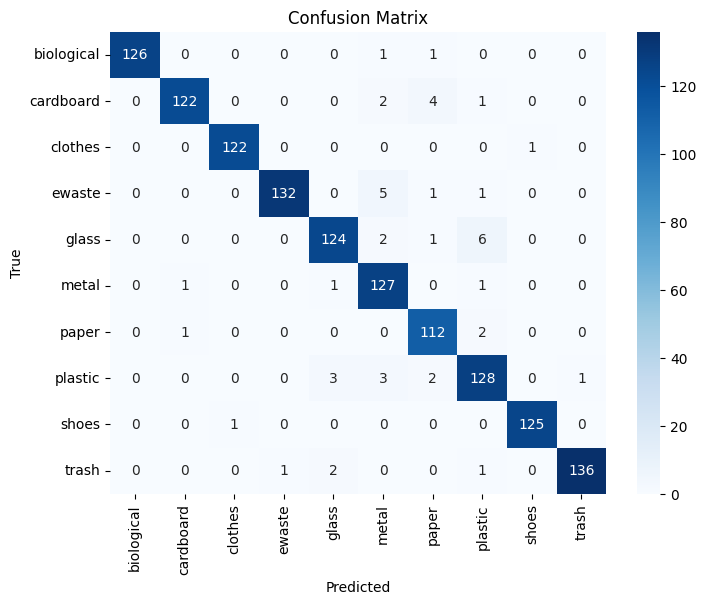

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
from sklearn.metrics import classification_report

# Display the classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

  biological       1.00      0.98      0.99       128
   cardboard       0.98      0.95      0.96       129
     clothes       0.99      0.99      0.99       123
      ewaste       0.99      0.95      0.97       139
       glass       0.95      0.93      0.94       133
       metal       0.91      0.98      0.94       130
       paper       0.93      0.97      0.95       115
     plastic       0.91      0.93      0.92       137
       shoes       0.99      0.99      0.99       126
       trash       0.99      0.97      0.98       140

    accuracy                           0.96      1300
   macro avg       0.97      0.97      0.97      1300
weighted avg       0.97      0.96      0.96      1300



In [21]:
from tensorflow.keras.preprocessing import image

def predict_waste_type(img):
  img_array = image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  # Make a prediction
  predictions = model.predict(img_array)
  predicted_class_index = np.argmax(predictions)
  predicted_class_name = class_names[predicted_class_index]
  prediction_confidence = predictions[0][predicted_class_index]

  print(f"The predicted class is: {predicted_class_name}")
  print(f"Confidence is: {(prediction_confidence * 100):.2f}%")

  # Display the image
  plt.imshow(img)
  plt.title(f"Predicted: {predicted_class_name}")
  plt.axis("off")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
The predicted class is: plastic
Confidence is: 99.99%


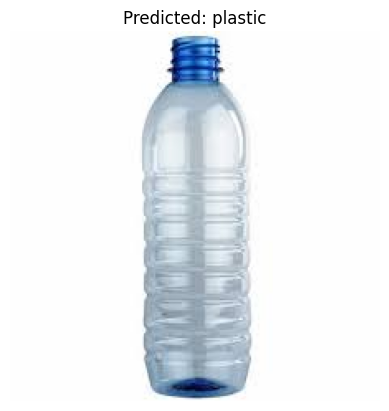

In [22]:
img_path = '/content/plastic_bottle.jpeg'
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
predict_waste_type(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The predicted class is: glass
Confidence is: 99.36%


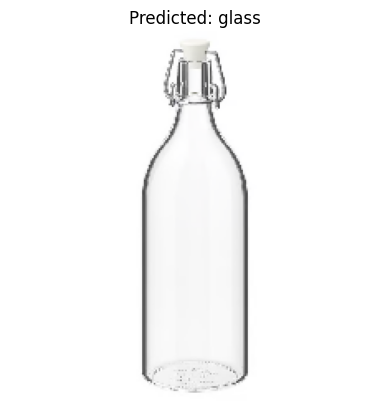

In [23]:
img_path = '/content/glass.png'
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
predict_waste_type(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The predicted class is: biological
Confidence is: 99.77%


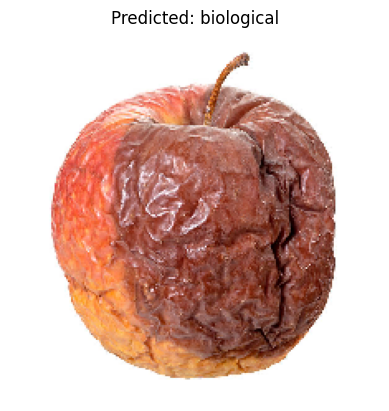

In [25]:
img_path = '/content/rotten-apple.jpg'
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
predict_waste_type(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted class is: clothes
Confidence is: 37.70%


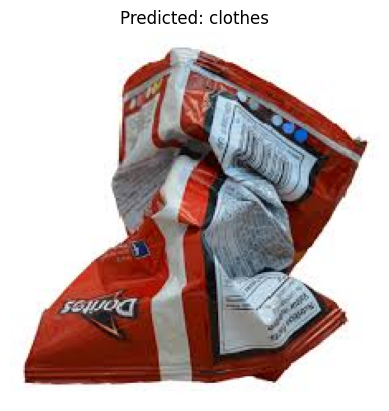

In [26]:
img_path = '/content/chip_bag.jpg'
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
predict_waste_type(img)

# Saving model

In [28]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("waste_classification_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpukyjvba_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134026671330448: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134026671332368: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134026688647760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688651984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688651600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688652752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688650448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688650640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688653904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134026688654096: TensorSpec(shape=(), dtype=tf.resource, name